In [29]:
import os
from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyro
import seaborn as sns
import torch
from math import ceil, floor
import functools
import dill
import sys

import bayes_air.utils.dataloader as ba_dataloader
from bayes_air.model import augmented_air_traffic_network_model_simplified
from bayes_air.network import NetworkState, AugmentedNetworkState
from bayes_air.schedule import split_and_parse_full_schedule

from scripts.lga.lga_network import *

from tqdm.notebook import tqdm


In [69]:
rng_seed = 1

pyro.clear_param_store()  # avoid leaking parameters across runs
pyro.enable_validation(True)
pyro.set_rng_seed(int(rng_seed))

day_strs_list = [['2019-07-04'], ['2019-07-10'], ['2019-07-18']]
network_airport_codes = ['LGA']
dt = .1

device = torch.device("cpu")

# Hyperparameters
initial_aircraft = 50.0 # not used!
mst_effective_hrs = 24 # not used!
mst_split = 1 # not really used

subsamples = {}

for day_strs in day_strs_list:
    # gather data
    days = pd.to_datetime(day_strs)
    data = ba_dataloader.load_remapped_data_bts(days)
    name = day_strs[0]

    num_days = len(days)
    num_flights = sum([len(df) for df in data.values()])

    # make things with the data
    travel_times_dict, observations_df = \
        make_travel_times_dict_and_observation_df(
            data, network_airport_codes
        ) 
    states = make_states(data, network_airport_codes)

    model = functools.partial(
        augmented_air_traffic_network_model_simplified,

        travel_times_dict=travel_times_dict,
        initial_aircraft=initial_aircraft,

        include_cancellations=False,
        mean_service_time_effective_hrs=mst_effective_hrs,
        delta_t=dt,

        source_use_actual_departure_time=True,
        source_use_actual_cancelled=False,
    )

    subsamples[name] = {
        "model": model,
        "states": states,
        "travel_times_dict": travel_times_dict,
        "observations_df": observations_df,
    }

print(subsamples.keys())

dict_keys(['2019-07-04', '2019-07-10', '2019-07-18'])


In [52]:
def get_samples_df(name, mst, n):
    sdd = pd.DataFrame()
    add = None
    for i in tqdm(range(n)):
        posterior_samples = {
            'LGA_0_mean_service_time': torch.tensor([mst]).to(device)
        }
        s = subsamples[name]
        model, states, observations_df = s["model"], s["states"], s["observations_df"]
        hourly_delays = get_hourly_delays_from_z_sample(model, posterior_samples, states, observations_df)
        sdd[i] = hourly_delays.sample_departure_delay
        if i == 0:
            add = hourly_delays.actual_departure_delay
    return sdd, add


In [57]:
sdd_a, add_a = get_samples_df('2019-07-04', .020, 20)
display(sdd_a)
display(add_a)

  0%|          | 0/20 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
5,-0.000497,-0.003398,0.029089,0.038415,-0.011993,0.022569,0.040954,0.011310,0.037963,0.004637,-0.001408,0.011586,0.017474,-0.006631,0.061229,0.014168,0.000342,-0.009115,0.022112,0.004981
6,0.045950,0.068992,0.047224,0.063040,0.072073,0.078829,0.069560,0.077788,0.065835,0.093457,0.049982,0.068236,0.120844,0.070564,0.092827,0.107198,0.058958,0.058844,0.060649,0.057864
7,0.073343,0.044849,0.055138,0.082325,0.109844,0.103677,0.091643,0.056275,0.073613,0.092981,0.045359,0.119396,0.100487,0.094469,0.087890,0.071795,0.052517,0.063799,0.050167,0.082429
8,0.153431,0.259660,0.352195,0.096592,0.181805,0.206261,0.147275,0.194299,0.155071,0.137776,0.135379,0.213409,0.197793,0.262047,0.291766,0.131512,0.147346,0.153858,0.277121,0.151801
9,0.244920,0.323303,0.513306,0.250611,0.338955,0.329531,0.258798,0.329452,0.257150,0.201290,0.228047,0.410952,0.357915,0.490726,0.301437,0.267505,0.305597,0.279532,0.422670,0.261512
10,0.246528,0.493684,0.639542,0.383269,0.529218,0.356323,0.442833,0.575826,0.462694,0.310936,0.527162,0.547918,0.535050,0.666595,0.535836,0.696956,0.448119,0.625191,0.752561,0.423096
11,0.369474,0.482774,0.753940,0.290668,0.701892,0.324114,0.498863,0.695719,0.510220,0.299176,0.621964,0.534944,0.518380,0.617861,0.464832,0.770334,0.474483,0.609389,0.949838,0.478985
12,0.434462,0.312588,0.692668,0.196102,0.711782,0.314634,0.511497,0.681067,0.541820,0.194705,0.478525,0.511003,0.465305,0.457317,0.452838,0.944659,0.291221,0.725998,0.998292,0.635005
13,0.384502,0.285014,0.498893,0.119383,0.866116,0.336875,0.438766,0.649585,0.696114,0.197016,0.374018,0.547878,0.325338,0.371218,0.417469,1.039582,0.206047,0.614983,1.010404,0.547732
14,0.305897,0.262420,0.296257,0.121800,0.592783,0.378600,0.387272,0.532537,0.510211,0.213298,0.186318,0.313271,0.265276,0.377917,0.368359,1.032317,0.171699,0.468467,0.763017,0.376638


5    -0.022917
6    -0.064167
7     0.006061
8    -0.066049
9    -0.036275
10    0.062667
11    0.053472
12   -0.024167
13   -0.062500
14    0.021053
15    0.096032
16   -0.065556
17   -0.042424
18    0.122222
19    0.776667
20    0.433333
21    0.194444
22   -0.100000
23         NaN
Name: actual_departure_delay, dtype: float64

<Axes: >

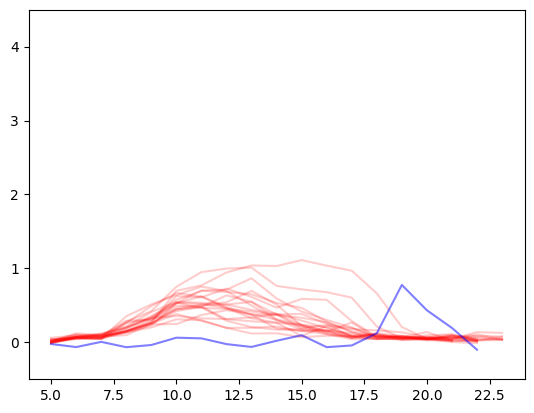

In [68]:
sdd_a.plot(legend=False, style='-r', alpha=.2, ylim=(-.5,4.5))
add_a.plot(legend=False, style='-b', alpha=.5, ylim=(-.5,4.5))

In [59]:
sdd_b, add_b = get_samples_df('2019-07-10', .020, 20)
display(sdd_b)

  0%|          | 0/20 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
5,-0.005818,0.008756,0.012148,-0.006332,0.053052,0.069168,0.022456,0.008647,0.006460,0.065196,-0.015078,0.076440,-0.000821,0.016447,0.004288,0.018736,0.034746,-0.006781,0.011810,0.018077
6,0.142546,0.128361,0.149960,0.166813,0.254320,0.147350,0.083059,0.136735,0.121225,0.133514,0.104714,0.149560,0.124699,0.169366,0.105840,0.167403,0.130811,0.274524,0.121463,0.172068
7,0.128233,0.122548,0.066103,0.108166,0.095427,0.146429,0.165509,0.098057,0.086754,0.137988,0.132592,0.089667,0.145716,0.159586,0.167385,0.158113,0.112935,0.228880,0.112226,0.150135
8,0.360900,0.396991,0.300725,0.417249,0.293900,0.480539,0.392394,0.401234,0.294778,0.474987,0.523112,0.342717,0.409228,0.592799,0.514322,0.460573,0.484665,0.622519,0.331837,0.461646
9,0.665480,0.768497,0.670050,0.630471,0.668405,0.692488,0.702897,0.557514,0.633189,0.767305,0.756664,0.717824,0.719182,0.931397,0.856736,0.771005,0.804682,0.819594,0.667479,0.850790
10,0.914197,1.172210,1.041348,0.895540,0.955993,0.923188,1.210483,0.932969,1.035879,1.127628,1.117523,1.284833,0.919560,1.263237,1.173202,1.046258,1.184398,1.305718,1.124046,1.079645
11,1.343124,1.476218,1.512365,1.260879,1.083614,1.246249,1.430258,1.072641,1.349312,1.428528,1.385994,1.596624,1.317978,1.505763,1.681707,1.274381,1.540715,1.620762,1.495501,1.408080
12,1.396936,1.732728,1.685930,1.433672,1.295477,1.314414,1.746632,1.227726,1.539144,1.700154,1.519315,1.900540,1.542056,1.719194,1.696722,1.524514,1.620063,1.866837,1.723966,1.612620
13,1.625070,1.784678,2.054249,1.595021,1.496824,1.427716,2.083259,1.480894,1.722352,1.826155,1.946579,2.006152,1.717259,2.015477,1.891970,1.739877,1.936734,2.151084,1.907107,1.851979
14,1.745576,2.074963,2.159581,1.856412,1.626237,1.676552,2.256433,1.490601,1.951730,1.789202,2.124239,2.177783,1.940860,2.258805,1.908377,2.024445,2.014863,2.272796,2.189770,2.085906


<Axes: >

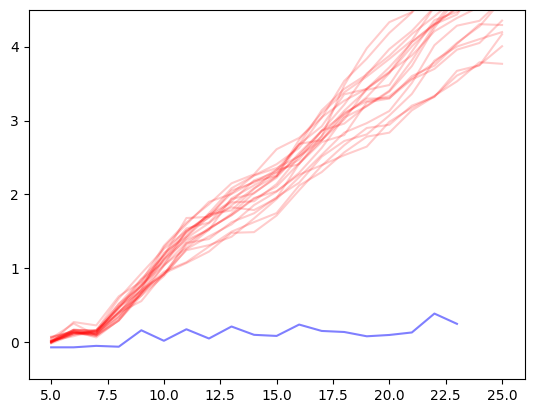

In [67]:
sdd_b.plot(legend=False, style='-r', alpha=.2, ylim=(-.5,4.5))
add_b.plot(legend=False, style='-b', alpha=.5, ylim=(-.5,4.5))

In [74]:
from pathlib import Path

dir_path = Path.cwd()

# /bayes-air-atrds-attempt-8/checkpoints/nsf_730
ckpt_path = dir_path / 'bayes-air-atrds-attempt-8/final/nsf_730/final/output_dict.pkl'

with open(ckpt_path, 'rb') as f:
    output_dict = dill.load(f)

guide = output_dict['guide']


from scripts.lga.lga_training import WeatherThreshold, ClusterThreshold

wt = WeatherThreshold(50., device, 0., 0.)
ct = ClusterThreshold(50., device, 0., 0.) # dummy init

wt.load_state_dict(output_dict['wt_state_dict'])
ct.load_state_dict(output_dict['ct_state_dict'])

extras_path = dir_path / 'extras'

processed_visibility = pd.read_csv(extras_path / 'processed_visibility.csv')
visibility_dict = dict(processed_visibility.values)
processed_ceiling = pd.read_csv(extras_path / 'processed_ceiling.csv')
ceiling_dict = dict(processed_ceiling.values)

processed_x = pd.read_csv(extras_path / 'x_capacity_counts.csv') # TODO: option
x_dict = dict(processed_x.values)
processed_y = pd.read_csv(extras_path / 'y_event_delays.csv') # TODO: option
y_dict = dict(processed_y.values)

y_threshold = output_dict["y_th"]
x_threshold = output_dict["x_th"]



In [78]:
name = '2019-07-18'

y = y_dict[name]
x = x_dict[name]
y_label = 1.0 if y > y_threshold else 0.0
x_label = 1.0 if x > x_threshold else 0.0
y_label = torch.tensor([y_label])
x_label = torch.tensor([x_label])

label = ct.assign_label(y_label, x_label, visibility_dict[name], ceiling_dict[name])
print(label)

def transform_sample(sample):
    return .004 * sample + .02

print(transform_sample(guide(label).sample((10,))))

tensor([0., 0., 0., 1., 1.], grad_fn=<IndexPutBackward0>)
tensor([[0.0152],
        [0.0161],
        [0.0159],
        [0.0151],
        [0.0166],
        [0.0165],
        [0.0157],
        [0.0156],
        [0.0143],
        [0.0160]])


In [79]:
def get_samples_df_using_guide(name, guide, label, n):
    sdd = pd.DataFrame()
    add = None
    samples = transform_sample(guide(label).sample((n,)))
    for i in tqdm(range(n)):
        posterior_samples = {
            'LGA_0_mean_service_time': samples[i]
        }
        s = subsamples[name]
        model, states, observations_df = s["model"], s["states"], s["observations_df"]
        hourly_delays = get_hourly_delays_from_z_sample(model, posterior_samples, states, observations_df)
        sdd[i] = hourly_delays.sample_departure_delay
        if i == 0:
            add = hourly_delays.actual_departure_delay
    return sdd, add

In [80]:
sdd_c, add_c = get_samples_df_using_guide('2019-07-18', guide, label, 20)
display(sdd_c)
display(add_c)

  0%|          | 0/20 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
5,0.002918,0.023996,-0.000905,0.039142,0.034228,0.019373,-0.009229,-0.007328,0.019854,-0.009834,-0.005508,0.002977,0.027848,0.003789,0.006536,0.016856,0.001131,-0.003290,-0.004592,0.005790
6,0.145440,0.092679,0.117937,0.073069,0.128068,0.116974,0.110610,0.090934,0.078338,0.096705,0.098635,0.088248,0.127669,0.117264,0.072299,0.158304,0.156299,0.149706,0.087200,0.101564
7,0.066241,0.071437,0.126689,0.127013,0.149372,0.139202,0.076779,0.054398,0.062670,0.053481,0.067220,0.118676,0.122172,0.117599,0.061167,0.149698,0.191974,0.073969,0.088152,0.051506
8,0.221807,0.270989,0.320903,0.322186,0.428525,0.348359,0.384619,0.141848,0.261680,0.189307,0.315304,0.166004,0.274734,0.321485,0.192714,0.368127,0.371488,0.347655,0.167361,0.256671
9,0.325332,0.373953,0.649152,0.496515,0.608999,0.601993,0.671143,0.180705,0.449725,0.301541,0.384819,0.261355,0.463206,0.579149,0.326114,0.669883,0.625279,0.685549,0.332171,0.507168
10,0.431774,0.641386,0.991762,0.623725,0.804901,0.790851,0.793292,0.442413,0.746885,0.496040,0.696072,0.358758,0.486807,0.824476,0.524527,0.853124,0.741621,0.940073,0.492793,0.688197
11,0.424326,0.488348,1.286657,0.828227,0.913745,1.096353,0.968030,0.515331,0.669577,0.533228,0.581985,0.449034,0.583628,1.175984,0.355099,1.090698,0.947066,1.103463,0.630879,0.834049
12,0.263561,0.440206,1.704506,1.010435,0.867570,1.044932,0.873530,0.476787,0.583147,0.460952,0.483169,0.397388,0.481542,1.137679,0.145642,1.056474,0.737570,0.983959,0.481561,0.653589
13,0.263324,0.527100,1.703576,1.062814,0.846773,1.211523,0.787537,0.495636,0.696923,0.430273,0.492013,0.404758,0.502429,1.141641,0.277080,1.291521,0.725948,0.873085,0.511172,0.654884
14,0.245535,0.489570,1.718361,0.985205,0.771365,1.518079,0.709298,0.451385,0.657100,0.393443,0.606935,0.421848,0.526672,1.120941,0.345960,1.334384,0.693294,0.832666,0.458647,0.553565


5    -0.050000
6     0.032796
7     0.189815
8     0.219892
9     0.138889
10    0.535859
11    0.833333
12    0.486111
13    0.501786
14    0.747475
15    0.327586
16    0.800694
17    0.599306
18    1.050725
19    1.136111
20    1.600000
21    1.847396
22    1.894737
23    2.530769
24    3.438889
Name: actual_departure_delay, dtype: float64

<Axes: >

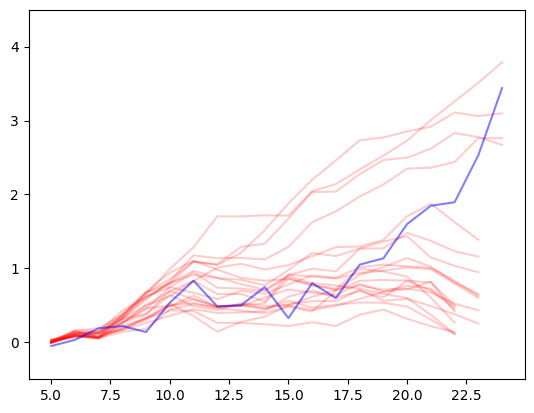

In [81]:
sdd_c.plot(legend=False, style='-r', alpha=.2, ylim=(-.5,4.5))
add_c.plot(legend=False, style='-b', alpha=.5, ylim=(-.5,4.5))